<a href="https://colab.research.google.com/github/nikitakaraevv/pointnet/blob/master/nbs/PointNetClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PointNet

This is an implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593) using PyTorch.


## Getting started

Don't forget to turn on GPU if you want to start training directly. 


**Runtime** -> **Change runtime type**-> **Hardware accelerator**



In [1]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

In [2]:
!pip install path.py;
from path import Path

In [3]:
random.seed = 42

Download the [dataset](http://3dvision.princeton.edu/projects/2014/3DShapeNets/) directly to the Google Colab Runtime. It comprises 10 categories, 3,991 models for training and 908 for testing.

In [4]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2021-06-21 12:12:26--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: 'ModelNet10.zip'

     0K .......... .......... .......... .......... ..........  0% 50.0K 2h34m
    50K .......... .......... .......... .......... ..........  0%  148K 1h42m
   100K .......... .......... .......... .......... ..........  0%  132K 88m10s
   150K .......... .......... .......... .......... ..........  0% 1.47M 67m24s
   200K .......... .......... .......... .......... ..........  0%  103K 68m49s
   250K .......... .......... .......... .......... ..........  0%  122K 67m50s
   300K .......... .......... .......... .......... ..........  0% 97.7K 69m24s
   350K .......... .......... .......... .......... ....

  8100K .......... .......... .......... .......... ..........  1% 7.06M 13m35s
  8150K .......... .......... .......... .......... ..........  1% 6.79M 13m31s
  8200K .......... .......... .......... .......... ..........  1% 6.24M 13m26s
  8250K .......... .......... .......... .......... ..........  1% 7.56M 13m22s
  8300K .......... .......... .......... .......... ..........  1% 9.35M 13m17s
  8350K .......... .......... .......... .......... ..........  1% 3.69M 13m13s
  8400K .......... .......... .......... .......... ..........  1% 1.84M 13m9s
  8450K .......... .......... .......... .......... ..........  1%  394K 13m11s
  8500K .......... .......... .......... .......... ..........  1% 1.51M 13m8s
  8550K .......... .......... .......... .......... ..........  1%  689K 13m8s
  8600K .......... .......... .......... .......... ..........  1% 8.60M 13m3s
  8650K .......... .......... .......... .......... ..........  1% 2.85M 13m0s
  8700K .......... .......... .......... ....

 49600K .......... .......... .......... .......... .......... 10% 1.98M 5m12s
 49650K .......... .......... .......... .......... .......... 10% 1.97M 5m12s
 49700K .......... .......... .......... .......... .......... 10%  658K 5m12s
 49750K .......... .......... .......... .......... .......... 10% 5.10M 5m12s
 49800K .......... .......... .......... .......... .......... 10% 1.13M 5m12s
 49850K .......... .......... .......... .......... .......... 10% 1.13M 5m12s
 49900K .......... .......... .......... .......... .......... 10% 1.68M 5m12s
 49950K .......... .......... .......... .......... .......... 10% 1.36M 5m12s
 50000K .......... .......... .......... .......... .......... 10%  818K 5m12s
 50050K .......... .......... .......... .......... .......... 10% 1.54M 5m12s
 50100K .......... .......... .......... .......... .......... 10% 1.53M 5m11s
 50150K .......... .......... .......... .......... .......... 10% 1.21M 5m11s
 50200K .......... .......... .......... .......... 

124550K .......... .......... .......... .......... .......... 26% 1.55M 3m54s
124600K .......... .......... .......... .......... .......... 26% 1.69M 3m54s
124650K .......... .......... .......... .......... .......... 26% 2.31M 3m54s
124700K .......... .......... .......... .......... .......... 26% 3.04M 3m53s
124750K .......... .......... .......... .......... .......... 26% 1.10M 3m53s
124800K .......... .......... .......... .......... .......... 27% 1.13M 3m53s
124850K .......... .......... .......... .......... .......... 27%  995K 3m53s
124900K .......... .......... .......... .......... .......... 27%  494K 3m54s
124950K .......... .......... .......... .......... .......... 27% 5.80M 3m53s
125000K .......... .......... .......... .......... .......... 27% 6.79M 3m53s
125050K .......... .......... .......... .......... .......... 27% 3.49M 3m53s
125100K .......... .......... .......... .......... .......... 27% 1.21M 3m53s
125150K .......... .......... .......... .......... 

194250K .......... .......... .......... .......... .......... 42% 1021K 3m19s
194300K .......... .......... .......... .......... .......... 42%  559K 3m19s
194350K .......... .......... .......... .......... .......... 42% 3.47M 3m19s
194400K .......... .......... .......... .......... .......... 42% 1.16M 3m19s
194450K .......... .......... .......... .......... .......... 42%  840K 3m19s
194500K .......... .......... .......... .......... .......... 42%  563K 3m19s
194550K .......... .......... .......... .......... .......... 42% 2.69M 3m19s
194600K .......... .......... .......... .......... .......... 42% 55.3K 3m20s
194650K .......... .......... .......... .......... .......... 42%  114M 3m20s
194700K .......... .......... .......... .......... .......... 42% 3.09M 3m20s
194750K .......... .......... .......... .......... .......... 42% 6.37M 3m20s
194800K .......... .......... .......... .......... .......... 42% 94.7M 3m20s
194850K .......... .......... .......... .......... 

249550K .......... .......... .......... .......... .......... 53% 5.10M 2m31s
249600K .......... .......... .......... .......... .......... 54% 5.91M 2m31s
249650K .......... .......... .......... .......... .......... 54% 9.34M 2m31s
249700K .......... .......... .......... .......... .......... 54% 4.77M 2m31s
249750K .......... .......... .......... .......... .......... 54% 4.38M 2m31s
249800K .......... .......... .......... .......... .......... 54% 3.80M 2m31s
249850K .......... .......... .......... .......... .......... 54% 2.42M 2m31s
249900K .......... .......... .......... .......... .......... 54% 4.80M 2m31s
249950K .......... .......... .......... .......... .......... 54%  475K 2m31s
250000K .......... .......... .......... .......... .......... 54% 5.02M 2m31s
250050K .......... .......... .......... .......... .......... 54% 7.55M 2m30s
250100K .......... .......... .......... .......... .......... 54% 4.51M 2m30s
250150K .......... .......... .......... .......... 

324500K .......... .......... .......... .......... .......... 70% 3.73M 94s
324550K .......... .......... .......... .......... .......... 70% 3.05M 94s
324600K .......... .......... .......... .......... .......... 70% 1.55M 94s
324650K .......... .......... .......... .......... .......... 70% 2.20M 94s
324700K .......... .......... .......... .......... .......... 70% 3.18M 94s
324750K .......... .......... .......... .......... .......... 70% 2.42M 94s
324800K .......... .......... .......... .......... .......... 70% 1.02M 94s
324850K .......... .......... .......... .......... .......... 70% 1.06M 94s
324900K .......... .......... .......... .......... .......... 70% 8.03M 94s
324950K .......... .......... .......... .......... .......... 70% 6.89M 94s
325000K .......... .......... .......... .......... .......... 70% 4.49M 94s
325050K .......... .......... .......... .......... .......... 70% 8.94M 93s
325100K .......... .......... .......... .......... .......... 70% 2.90M 93s

398250K .......... .......... .......... .......... .......... 86%  957K 45s
398300K .......... .......... .......... .......... .......... 86%  595K 45s
398350K .......... .......... .......... .......... .......... 86%  883K 45s
398400K .......... .......... .......... .......... .......... 86%  464K 45s
398450K .......... .......... .......... .......... .......... 86%  256K 45s
398500K .......... .......... .......... .......... .......... 86% 8.09M 45s
398550K .......... .......... .......... .......... .......... 86% 6.31M 45s
398600K .......... .......... .......... .......... .......... 86% 84.1K 45s
398650K .......... .......... .......... .......... .......... 86% 3.49M 45s
398700K .......... .......... .......... .......... .......... 86% 49.2M 45s
398750K .......... .......... .......... .......... .......... 86% 1.29M 44s
398800K .......... .......... .......... .......... .......... 86% 1.37M 44s
398850K .......... .......... .......... .......... .......... 86% 67.2M 44s

In [5]:
!unzip -q ModelNet10.zip;

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
path = Path("ModelNet10\ModelNet10")

In [5]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

This dataset consists of **.off** files that contain meshes represented by *vertices* and *triangular faces*. 

We will need a function to read this type of files:

In [6]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [22]:
with open(path/"chair/train/chair_0003.off", 'r') as f:
  verts, faces = read_off(f)

In [23]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [24]:
len(x)

7884

Don't be afraid of this huge function. It's  just to display animated rotation of meshes and point clouds.

In [25]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [26]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='skyblue', opacity=0.50, i=i,j=j,k=k)]).show()

This mesh definitely looks like a bed.

In [27]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')]).show()

Unfortunately, that's not the case for its vertices. It would be difficult for PointNet to classify point clouds like this one.

First things first, let's write a function to accurately visualize point clouds so we could see vertices better.

In [28]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()
    

In [29]:
pcshow(x,y,z)

## Transforms

As we want it to look more like a real bed, let's write a function to sample points on the surface uniformly.

 ### Sample points

In [30]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [31]:
pointcloud = PointSampler(3000)((verts, faces))

In [32]:
pcshow(*pointcloud.T)

This pointcloud looks much more like a bed!

### Normalize

Unit sphere

In [33]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [34]:
norm_pointcloud = Normalize()(pointcloud)

In [35]:
pcshow(*norm_pointcloud.T)

Notice that axis limits have changed.

### Augmentations

Let's add *random rotation* of the whole pointcloud and random noise to its points.

In [38]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [39]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [40]:
pcshow(*noisy_rot_pointcloud.T)

### ToTensor

In [41]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [42]:
ToTensor()(noisy_rot_pointcloud)

tensor([[-0.2347,  0.4412, -0.7494],
        [-0.1081,  0.1800, -0.0047],
        [ 0.3264,  0.3775, -0.4785],
        ...,
        [-0.0867, -0.2328,  0.6987],
        [ 0.0946, -0.1573,  0.1229],
        [ 0.0685, -0.2083,  0.1881]], dtype=torch.float64)

In [43]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

## Dataset

Now we can create a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [44]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

Transforms for training. 1024 points per cloud as in the paper!

In [45]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [46]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [47]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [48]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [60]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## Model

In [49]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [50]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

## Training loop

You can find a pretrained model [here](https://drive.google.com/open?id=1nDG0maaqoTkRkVsOLtUAR9X3kn__LMSL)

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [52]:
pointnet = PointNet()
pointnet.to(device);
pointnet

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [53]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [61]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch),".pth")

In [ ]:
train(pointnet, train_loader, valid_loader,  save=False)

[Epoch: 1, Batch:   10 /  125], loss: 0.352
[Epoch: 1, Batch:   20 /  125], loss: 0.340
[Epoch: 1, Batch:   30 /  125], loss: 0.334
[Epoch: 1, Batch:   40 /  125], loss: 0.349
[Epoch: 1, Batch:   50 /  125], loss: 0.322
[Epoch: 1, Batch:   60 /  125], loss: 0.277
[Epoch: 1, Batch:   70 /  125], loss: 0.277
[Epoch: 1, Batch:   80 /  125], loss: 0.414
[Epoch: 1, Batch:   90 /  125], loss: 0.332
[Epoch: 1, Batch:  100 /  125], loss: 0.429
[Epoch: 1, Batch:  110 /  125], loss: 0.386
[Epoch: 1, Batch:  120 /  125], loss: 0.268
Valid accuracy: 85 %
[Epoch: 2, Batch:   10 /  125], loss: 0.353
[Epoch: 2, Batch:   20 /  125], loss: 0.328
[Epoch: 2, Batch:   30 /  125], loss: 0.375
[Epoch: 2, Batch:   40 /  125], loss: 0.394


## Test

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save.pth',map_location=torch.device('cpu')))
pointnet.eval();

In [58]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())
        


NameError: name 'valid_loader' is not defined

In [47]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[ 41,   9,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  97,   2,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  1,   2,   2,  34,   4,   0,  19,   4,  19,   1],
       [  0,   0,   0,   0,  41,   0,  44,   0,   1,   0],
       [  0,   0,   1,   0,  26,  71,   1,   1,   0,   0],
       [  0,   0,   1,   0,   6,   0,  79,   0,   0,   0],
       [  1,   1,   1,   0,   1,   0,   1,  95,   0,   0],
       [  0,   0,   0,   6,   0,   0,   1,   0,  93,   0],
       [  1,   1,  13,   0,   2,   0,   1,   1,   0,  81]], dtype=int64)

In [48]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


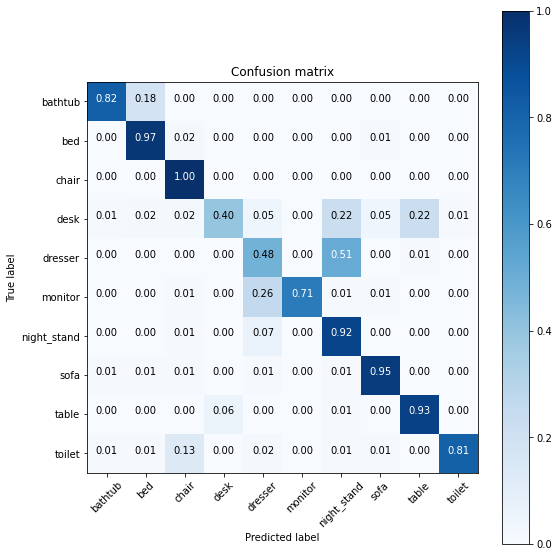

In [49]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


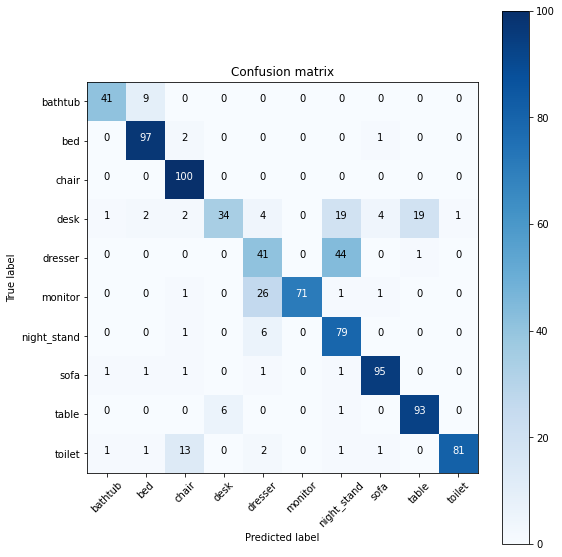

In [50]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

In [51]:
pip install plotly


You should consider upgrading via the 'c:\users\javed\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [7]:
pip install unzip

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement unzip (from versions: none)
ERROR: No matching distribution found for unzip


In [44]:
pip install sklearn


  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=c74b0ccd5256b29acd0d50cb8d5639c053106e6cb3b75ca3975355ba6f392b5d
  Stored in directory: c:\users\javed\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn

